In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.add("JuMP")
Pkg.add("Ipopt")
Pkg.instantiate()
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using JLD2
using Test
using Random
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))

  Activating project at `~/Documents/CMU-16-745/originals/HW2_S23`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Documents/CMU-16-745/originals/HW2_S23/Project.toml`
  No Changes to `~/Documents/CMU-16-745/originals/HW2_S23/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Documents/CMU-16-745/originals/HW2_S23/Project.toml`
  No Changes to `~/Documents/CMU-16-745/originals/HW2_S23/Manifest.toml`


animate_cartpole (generic function with 1 method)

# Q2: LQR for nonlinear systems (25 pts)

## Linearization warmup 
Before we apply LQR to nonlinear systems, we are going to treat our linear system as if it's nonlinear. Specifically, we are going to "approximate" our linear system with a first-order Taylor series, and define a new set of $(\Delta x, \Delta u)$ coordinates. Since our dynamics are linear, this approximation is exact, allowing us to check that we set up the problem correctly. 

First, assume our discrete time dynamics are the following:

$$ x_{k+1} = f(x_k,u_k) \qquad= rk4(x_k, u_k)$$

And we are going to linearize about a reference trajectory $\bar{x}_{1:N}, \bar{u}_{1:N-1}$. From here, we can define our delta's accordingly:

$$ \begin{align} x_k &= \bar{x}_k + \Delta x_k \\ u_k &= \bar{u}_k + \Delta u_k \end{align}$$  

Next, we are going to approximate our discrete time dynamics function with the following first order Taylor series:

$$ 
x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](x_k - \bar{x}_k) + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](u_k - \bar{u}_k)
$$

Which we can substitute in our delta notation to get the following:

$$ 
\bar{x}_{k+1} + \Delta x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

If the trajectory $\bar{x},\bar{u}$ is dynamically feasible (meaning $\bar{x}_{k+1} = f(\bar{x}_k, \bar{u}_k)$), then we can cancel these equivalent terms on each side of the above equation, resulting in the following:

$$ 
 \Delta x_{k+1} \approx  \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

## Cartpole 
We are now going to look at two different applications of LQR to the nonlinear cartpole system. Given the following description of the cartpole:
<div>
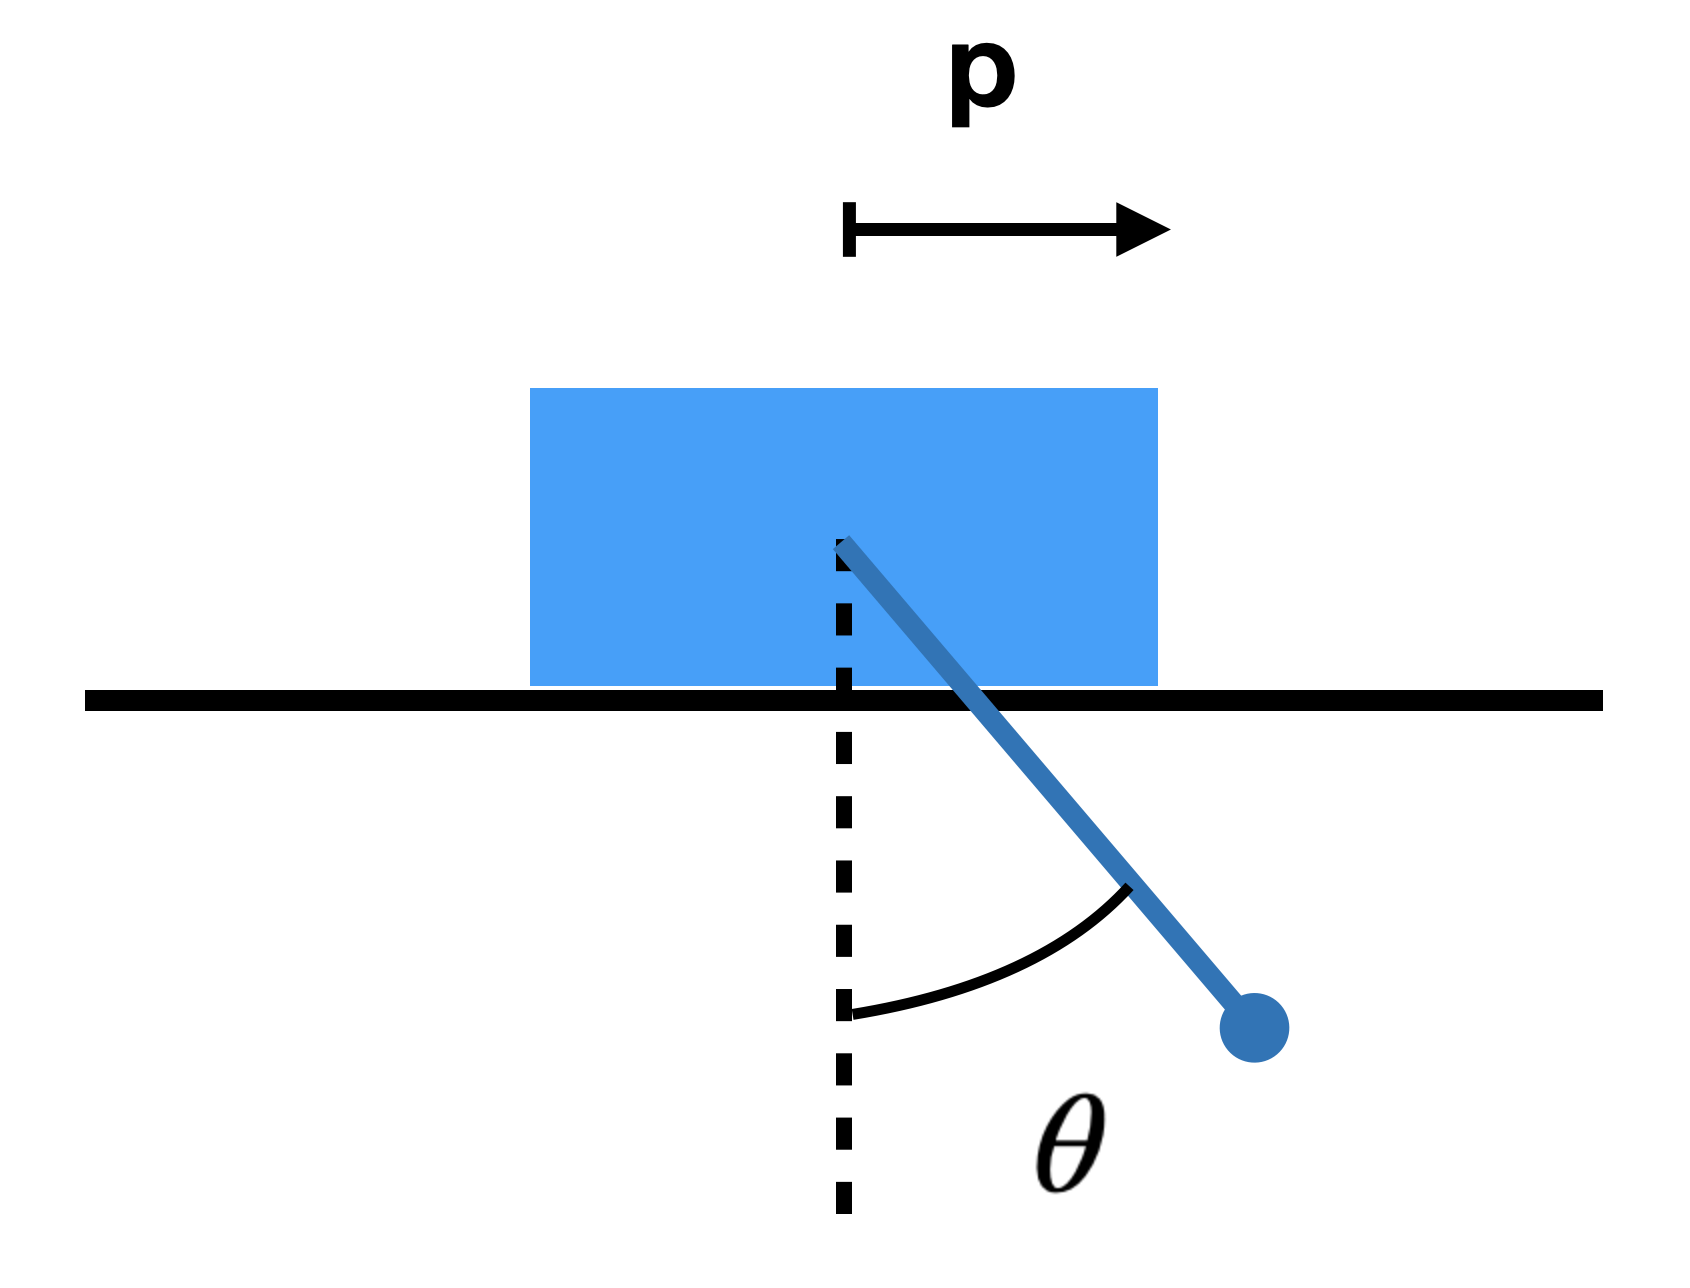
</div>
(if this image doesn't show up, check out `cartpole.png`)


with a cart position $p$ and pole angle $\theta$. We are first going to linearize the nonlinear discrete dynamics of this system about the point where $p = 0$, and $\theta = 0$ (no velocities), and use an infinite horizon LQR controller about this linearized state to stabilize the cartpole about this goal state.  The dynamics of the cartpole are parametrized by the mass of the cart, the mass of the pole, and the length of the pole. To simulate a "sim to real gap", we are going to design our controllers around an estimated set of problem parameters `params_est`, and simulate our system with a different set of problem parameters `params_real`. 

In [2]:
"""
continuous time dynamics for a cartpole, the state is 
x = [p, θ, ṗ, θ̇]
where p is the horizontal position, and θ is the angle
where θ = 0 has the pole hanging down, and θ = 180 is up.

The cartpole is parametrized by a cart mass `mc`, pole 
mass `mp`, and pole length `l`. These parameters are loaded 
into a `params::NamedTuple`. We are going to design the
controller for a estimated `params_est`, and simulate with 
`params_real`. 
"""
function dynamics(params::NamedTuple, x, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    return [qd;qdd]

end

function rk4(params::NamedTuple, x, u, dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

## Part A: Infinite Horizon LQR about an equilibrium (10 pts)
Here we are going to solve for the infinite horizon LQR gain, and use it to stabilize the cartpole about the unstable equilibrium. 

typeof(X) = Vector{Vector{Float64}}


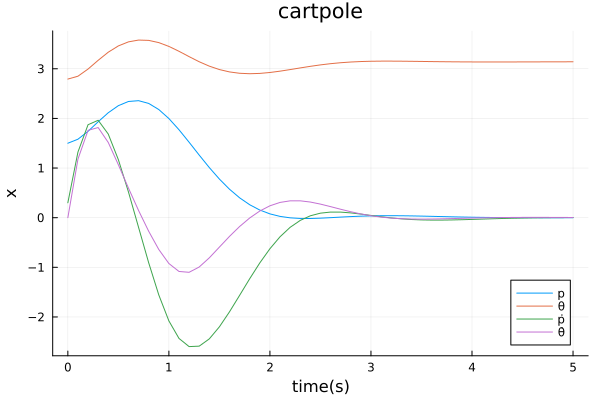

[ Info: Listening on: 127.0.0.1:8700, thread id: 1
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700))

Test Summary: | Pass  Total   Time
LQR about eq  |    3      3  26.3s


Test.DefaultTestSet("LQR about eq", Any[], 3, false, false, true, 1.697950350654397e9, 1.697950376951988e9, false)

In [3]:
function ihlqr(A::Matrix,       # vector of A matrices 
               B::Matrix,       # vector of B matrices
               Q::Matrix,       # cost matrix Q 
               R::Matrix;       # cost matrix R 
               max_iter = 1000, # max iterations for Ricatti 
               tol = 1e-5       # convergence tolerance
               )::Tuple{Matrix, Matrix} # return two matrices 
        
    # get size of x and u from B 
    nx, nu = size(B)
        
    # initialize S with Q
    P = deepcopy(Q)
    
    # Ricatti 
    for ricatti_iter = 1:max_iter 

        # TODO 
        K = (R + B' * P * B) \ (B' * P * A)
        P_k1 = Q + A' * P * (A - B*K)
        
        if norm(P - P_k1) ≤ tol
            return P_k1, K
        end
            
        P = P_k1

    end
    error("ihlqr did not converge")
end

@testset "LQR about eq" begin
    
    # states and control sizes 
    nx = 4 
    nu = 1 
    
    # desired x and g (linearize about these)
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    
    # initial condition (slightly off of our linearization point)
    x0 = [0, pi, 0, 0] + [1.5, deg2rad(-20), .3, 0]
    
    # simulation size 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0 
    
    # estimated parameters (design our controller with these)
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    
    # real paremeters (simulate our system with these)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: solve for the infinite horizon LQR gain Kinf
    # Linearize the discrete transition function
    A = FD.jacobian(x_ -> rk4(params_est, x_, ugoal, dt), xgoal) # ∂ wrt x at xgoal, ugoal
    B = FD.jacobian(u_ -> rk4(params_est, xgoal, u_, dt), ugoal) # ∂ wrt u at xgoal, ugoal
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    Qf = 1*Q
    R = 0.1*diagm(ones(nu))
    
    _, Kinf = ihlqr(A,B,Q,R)

    @show typeof(X)
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for i =1:N-1
        u = -Kinf * (X[i] - xgoal)
        X[i+1] = rk4(params_real, X[i], u, dt)
    end
    
    
    # ---------------tests and plots/animations---------------
    @test X[1] == x0 
    @test norm(X[end])>0
    @test norm(X[end] - xgoal) < 0.1 
    
    Xm = hcat(X...)
    display(plot(t_vec,Xm',title = "cartpole",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------
end

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.1.

Number of nonzeros in equality constraint Jacobian...:     1209
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      209
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  5.0268530e+02 1.50e+00 1.40e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00 

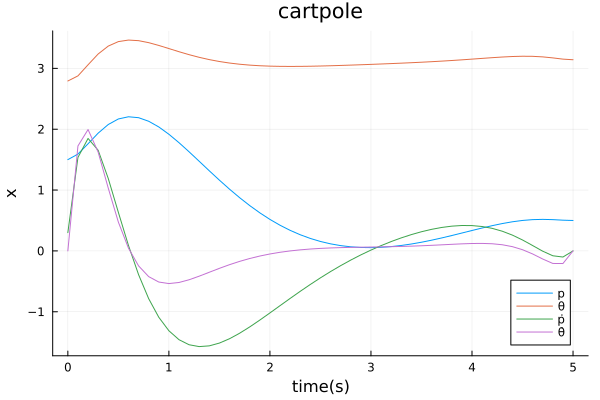

In [88]:
using JuMP
using Ipopt

# states and control sizes 
nx = 4 
nu = 1 

# desired x and g (linearize about these)
xgoal = [0, pi, 0, 0]
ugoal = [0]

# initial condition (slightly off of our linearization point)
x0 = [0, pi, 0, 0] + [1.5, deg2rad(-20), .3, 0]

# simulation size 
dt = 0.1 
tf = 5.0 
t_vec = 0:dt:tf
N = length(t_vec)
X = [zeros(nx) for i = 1:N]
X[1] = x0 
Q = diagm([1,1,.05,.1])
Qf = 1*Q
R = 0.1*diagm(ones(nu))
params = (mc = 1.0, mp = 0.2, l = 0.5)

# Feasible rollout 
U0 = repeat([0.1],1,N)
X0 = repeat(x0,1,N)
# Didn't work as well
# for k=1:N-1
#     X0[:,k+1] = rk4(params, X0[:,k], U0[:,k], dt)
# end

# Setup the problem
model = JuMP.Model(Ipopt.Optimizer)
JuMP.@variable(model, X[i=1:nx, j=1:N], start = X0[i,j])
JuMP.@variable(model, U[i=1:nu, j=1:N], start = U0[i,j])

# Create the nonlinear operators
# Note issue with performance, but I believe this would be purely in precompilation?
rk4_z(z) = rk4(params, z[1:nx], z[nx+1:nx+nu], dt)

# JuMP.@operator(model, op_f1, nx+nu, (x...) -> rk4_z(collect(x))[1])
# JuMP.@operator(model, op_f2, nx+nu, (x...) -> rk4_z(collect(x))[2])
# JuMP.@operator(model, op_f3, nx+nu, (x...) -> rk4_z(collect(x))[3])
# JuMP.@operator(model, op_f4, nx+nu, (x...) -> rk4_z(collect(x))[4])
# for k=1:N-1 # This is much faster
#     JuMP.@constraint(model, X[1,k+1] == op_f1([X[:,k]; U[:,k]]...))
#     JuMP.@constraint(model, X[2,k+1] == op_f2([X[:,k]; U[:,k]]...))
#     JuMP.@constraint(model, X[3,k+1] == op_f3([X[:,k]; U[:,k]]...))
#     JuMP.@constraint(model, X[4,k+1] == op_f4([X[:,k]; U[:,k]]...))
# end

# This is ~3x faster than above
# https://jump.dev/JuMP.jl/stable/tutorials/nonlinear/tips_and_tricks/
function memoize(foo::Function, n_outputs::Int)
    last_x, last_f = nothing, nothing
    last_dx, last_dfdx = nothing, nothing
    function foo_i(i, x::T...) where {T<:Real}
        if T == Float64
            if x !== last_x
                last_x, last_f = x, foo(x...)
            end
            return last_f[i]::T
        else
            if x !== last_dx
                last_dx, last_dfdx = x, foo(x...)
            end
            return last_dfdx[i]::T
        end
    end
    return [(x...) -> foo_i(i, x...) for i in 1:n_outputs]
end
rk4_splat(z...) = rk4(params, collect(z)[1:nx], collect(z)[nx+1:nx+nu], dt)
rk4_mem = memoize(rk4_splat, 4)

JuMP.@operator(model, op_f1, nx+nu, rk4_mem[1])
JuMP.@operator(model, op_f2, nx+nu, rk4_mem[2])
JuMP.@operator(model, op_f3, nx+nu, rk4_mem[3])
JuMP.@operator(model, op_f4, nx+nu, rk4_mem[4])
for k=1:N-1 # This is much faster
    JuMP.@constraint(model, X[1,k+1] == op_f1([X[:,k]; U[:,k]]...))
    JuMP.@constraint(model, X[2,k+1] == op_f2([X[:,k]; U[:,k]]...))
    JuMP.@constraint(model, X[3,k+1] == op_f3([X[:,k]; U[:,k]]...))
    JuMP.@constraint(model, X[4,k+1] == op_f4([X[:,k]; U[:,k]]...))
end

# Initial constraint
JuMP.@constraint(model, X[:,1] .== x0)

# Goal constraint
goal_con = JuMP.@constraint(model, X[:,N] .== xgoal)
JuMP.@constraint(model, U[:,N] .== ugoal)

# Cost constraint
JuMP.@objective(model, Min, begin
        sum(X[:,k]' * Q * X[:,k] for k in 1:N-1) + sum(U[:,k]' * R * U[:,k] for k in 1:N-1)
    end)

JuMP.optimize!(model)

# Note, on the second solve it is super fast.
JuMP.add_to_function_constant(goal_con[1], -0.5)
JuMP.optimize!(model)

@assert JuMP.termination_status(model) == JuMP.OPTIMAL || JuMP.termination_status(model) == JuMP.LOCALLY_SOLVED

Xm = JuMP.value.(X)
Xm = [Xm[:,k] for k in 1:N]

Xm = hcat(Xm...)
display(plot(t_vec,Xm',title = "cartpole",
             xlabel = "time(s)", ylabel = "x",
             label = ["p" "θ" "ṗ" "θ̇"]))


## Part B: TVLQR for trajectory tracking (15 pts)

Here we are given a swingup trajectory that works for `params_est`, but will fail to work with `params_real`. To account for this sim to real gap, we are going to track this trajectory with a TVLQR controller. 

In [ ]:
function tvlqr(As::Vector{Matrix{Float64}},       # vector of A matrices 
               Bs::Vector{Matrix{Float64}},       # vector of B matrices
               Q::Matrix,               # cost matrix Q 
               R::Matrix,               # cost matrix R 
               Qf::Matrix               # cost matrix Qf 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two vectors of matrices 
    
    # make sure A and B are same length 
    N = length(As) + 1 
    @assert length(Bs) == (N - 1)
    
    # get size of x and u from B 
    nx, nu = size(Bs[1])
    
    # instantiate S and K 
    S = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    S[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):(-1):1 
        A = As[k]
        B = Bs[k]
        K[k] = (R + B'*S[k+1]*B)\(B'*S[k+1]*A)
        S[k] = Q + K[k]'*R*K[k] + (A - B*K[k])'S[k+1]*(A - B*K[k])
    end
    
    return S, K 
end

@testset "track swingup" begin 
    
    # optimized trajectory we are going to try and track
    DATA = load(joinpath(@__DIR__,"swingup.jld2"))
    Xbar = DATA["X"]
    Ubar = DATA["U"]
    
    # states and controls 
    nx = 4 
    nu = 1 
    
    # problem size 
    dt = 0.05 
    tf = 4.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    # states (initial condition of zeros)
    X = [zeros(nx) for i = 1:N]
    X[1] = [0, 0, 0, 0.0] 
    
    # make sure we have the same initial condition 
    @assert norm(X[1] - Xbar[1]) < 1e-12
    
    # real and estimated params 
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: design a time-varying LQR controller to track this trajectory 
    # use params_est for your control design, and params_real for the simulation

    # Linearize about the trajectory
    As = [FD.jacobian(_x->rk4(params_est, _x, Ubar[i], dt), Xbar[i]) for i=1:(N-1)]
    Bs = [FD.jacobian(_u->rk4(params_est, Xbar[i], _u, dt), Ubar[i]) for i=1:(N-1)]
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    Qf = 10*Q
    R = 0.05*diagm(ones(nu))

    # TODO: solve for tvlqr gains K
    # Solve for the gains with the linearised system
    S,K = tvlqr(As,Bs,Q,R,Qf)
    
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for i = 1:(N-1)
        Δx = X[i] - Xbar[i]
        Δu = -K[i]*Δx
        u = Ubar[i] + Δu
        X[i+1] = rk4(params_real, X[i], u, dt) 
    end
    
    
    
    # ---------------tests and plots/animations---------------
    xn = X[N]
    @test norm(xn)>0
    @test 1e-6<norm(xn - Xbar[end])<.2
    @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
    
    Xm = hcat(X...)
    Xbarm = hcat(Xbar...)
    plot(t_vec,Xbarm',ls=:dash, label = ["p̄" "θ̄" "ṗ̄" "θ̇̄"],lc = [:red :green :blue :black])
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------

    
end